# Run ridge classifer model on features

Ridge Regression is a type of Linear Regression in which the regularization term is added as a parameter. This regularization term is also known as L2 regularization. This is done so as to avoid overfitting. Overfitting is when the model performs excellently on training data but poorly on the test or unseen data. Regularization introduces penalties on higher terms so as to reduce loss as well as overfitting in the model.

In [1]:
import os
import sys
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader
from torchgeo.models import RCF
from tqdm import tqdm

sys.path.append("../utils")

import config
import data_utils

In [2]:
# Import training dataset
dataset = os.path.join(config.data_dir, "training_geometries", "training_gdf.parquet")

dataset = gpd.read_parquet(dataset)
dataset = dataset.drop(columns=["basemap_name", "geometry", "year", "month"])

In [16]:
# Import features
features = os.path.join(config.data_dir, "features", "features_mosaiks_4000.feather")
features = pd.read_feather(features)
features["unique_id"] = features.index

In [23]:
features

,unique_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,basemap_id
0,0,0.054892,0.0,0.015004,0.000000,0.238797,0.000466,0.0,0.055266,0.005605,...,0.767071,0.147397,1.374366,0.052267,2.742807,1.274291,1.905394,4.261047,2.500061,global_monthly_2020_11_mosaic
1,1,0.024470,0.0,0.003108,0.000000,0.129467,0.000687,0.0,0.034108,0.012225,...,0.879817,0.321159,1.269820,0.232065,2.272318,1.205103,1.661454,3.457836,2.098205,global_monthly_2020_11_mosaic
2,2,0.271383,0.0,0.126712,0.000000,0.976787,0.043854,0.0,0.528058,0.124882,...,0.804640,0.002047,1.700142,0.000000,3.815154,1.246298,2.504779,6.486201,3.454411,global_monthly_2020_11_mosaic
3,3,0.097084,0.0,0.037654,0.000000,0.549639,0.001046,0.0,0.240636,0.017580,...,0.910977,0.038368,1.496693,0.016924,3.105121,1.228030,2.112541,5.209030,2.868551,global_monthly_2020_11_mosaic
4,4,0.041986,0.0,0.008531,0.000000,0.253195,0.001353,0.0,0.036694,0.002605,...,0.834353,0.105199,1.338944,0.040597,2.683573,1.311833,1.853227,4.251881,2.500635,global_monthly_2020_11_mosaic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67575,67575,0.390350,0.0,0.262293,0.000786,1.184320,0.136650,0.0,0.574472,0.152560,...,0.768996,0.017736,1.741290,0.004315,4.085146,1.400683,2.625626,6.979860,3.755582,global_monthly_2020_06_mosaic
67576,67576,0.620665,0.0,0.296629,0.000000,1.358988,0.173100,0.0,0.705775,0.217716,...,0.792006,0.009270,1.698395,0.004601,4.216866,1.382952,2.644958,7.298834,3.850550,global_monthly_2020_06_mosaic
67577,67577,0.556022,0.0,0.353750,0.000000,1.496471,0.208025,0.0,0.853633,0.305501,...,0.735359,0.005294,1.890536,0.000650,4.559845,1.369144,2.898552,7.891863,4.150410,global_monthly_2020_06_mosaic
67578,67578,0.675105,0.0,0.384092,0.000000,1.633386,0.188037,0.0,0.909275,0.271135,...,0.677290,0.000074,1.897443,0.000000,4.699477,1.403599,2.952056,8.153236,4.270082,global_monthly_2020_06_mosaic


In [17]:
# Join to original dataset
joined = dataset.merge(
    features,
    how="left",
    left_on="unique_id",
    right_on="unique_id",
)

In [18]:
# Define features and target
X = joined.drop(columns=["basemap_id", "status", "quad_id", "unique_id", "Date"])
y = joined["status"]

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Initialize and fit ridge classifier model

In [19]:
# Initialize the model
ridge = RidgeClassifier(
    alpha=1.0,
    fit_intercept=True,
    copy_X=True,
    max_iter=None,
    tol=0.001,
    solver="auto",
    random_state=42,
)

# Fit the model
ridge.fit(X_train, y_train)

RidgeClassifier(random_state=42, tol=0.001)

#### Tune model hyperparameters and evaluate accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 0.01, 'class_weight': None, 'solver': 'auto'}
Best Cross-Validation Score: 0.5596228878785943

Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13432
           1       0.00      0.00      0.00        84

    accuracy                           0.99     13516
   macro avg       0.50      0.50      0.50     13516
weighted avg       0.99      0.99      0.99     13516



/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

ROC-AUC Score: 0.5236


<Figure size 800x600 with 0 Axes>

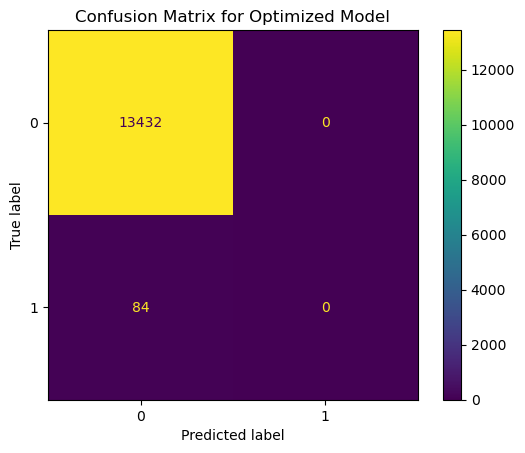

In [ ]:
# 1. First, let's create a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Define the parameter grid for our hyperparameter tuning
param_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "solver": ["auto"],
    "class_weight": [None, "balanced"],
}

# 3. Create the stratified k-fold cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Setup the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RidgeClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",  # Using ROC-AUC as the metric due to class imbalance
    n_jobs=-1,  # Use all available cores
    verbose=1,
)

# 5. Fit the grid search to find optimal hyperparameters
grid_search.fit(X_train, y_train)

# 6. Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 7. Get the best model
best_model = grid_search.best_estimator_

# 8. Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

# 9. Calculate and print ROC-AUC score
y_decision = best_model.decision_function(X_test)  # For AUC calculation
roc_auc = roc_auc_score(y_test, y_decision)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 10. Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.figure(figsize=(8, 6)), None
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title("Confusion Matrix for Optimized Model")
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'alpha': 10.0, 'class_weight': None, 'solver': 'auto'}
Best Cross-Validation Score: 0.5160239213993141

Test Set Performance:


/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

               precision    recall  f1-score   support

    Compliant       0.99      1.00      1.00     13429
Non-Compliant       0.00      0.00      0.00        87

     accuracy                           0.99     13516
    macro avg       0.50      0.50      0.50     13516
 weighted avg       0.99      0.99      0.99     13516

ROC-AUC Score: 0.5818


<Figure size 800x600 with 0 Axes>

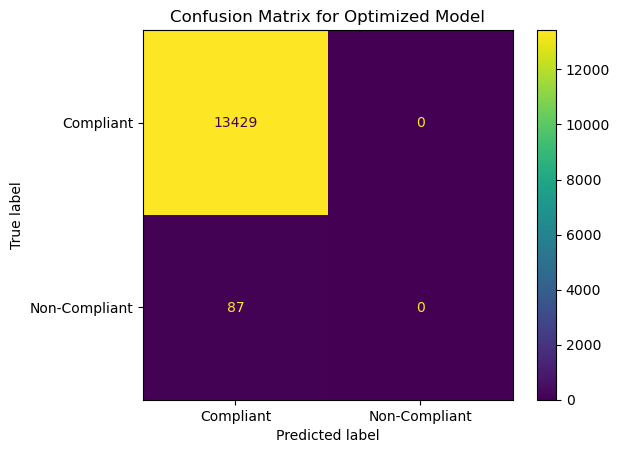

Year distribution in training set:
year
2019    0.217150
2020    0.175755
2021    0.209215
2022    0.200022
2023    0.197821
2024    0.000037
Name: proportion, dtype: float64
Year distribution in test set:
year
2019    0.217150
2020    0.175792
2021    0.209234
2022    0.200059
2023    0.197766
Name: proportion, dtype: float64


In [ ]:
# 1. First, extract the year from the 'Date' column
# Assuming your joined dataframe is called 'joined'
joined["year"] = pd.to_datetime(joined["Date"]).dt.year

# 2. Create a stratified train-test split by year
X = joined.drop(
    columns=["basemap_id", "status", "quad_id", "unique_id", "Date", "year"]
)
y = joined["status"]
stratify_by = joined["year"]

X_train, X_test, y_train, y_test, year_train, year_test = train_test_split(
    X, y, stratify_by, test_size=0.2, random_state=42, stratify=stratify_by
)

# 3. Define a smaller parameter grid
param_grid = {
    "alpha": [0.1, 1.0, 10.0],
    "solver": ["auto", "cholesky"],
    "class_weight": [None, "balanced"],
}

# 4. Setup cross-validation - Note: CV will still use stratification by label to ensure balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Setup the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RidgeClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

# 6. Fit the grid search to find optimal hyperparameters
grid_search.fit(X_train, y_train)

# 7. Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 8. Get the best model
best_model = grid_search.best_estimator_

# 9. Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

# 10. Calculate and print ROC-AUC score
y_decision = best_model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_decision)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 11. Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix for Optimized Model")
plt.show()

# 12. Check distribution of years in train and test sets to verify stratification
print("Year distribution in training set:")
print(year_train.value_counts(normalize=True).sort_index())

print("Year distribution in test set:")
print(year_test.value_counts(normalize=True).sort_index())

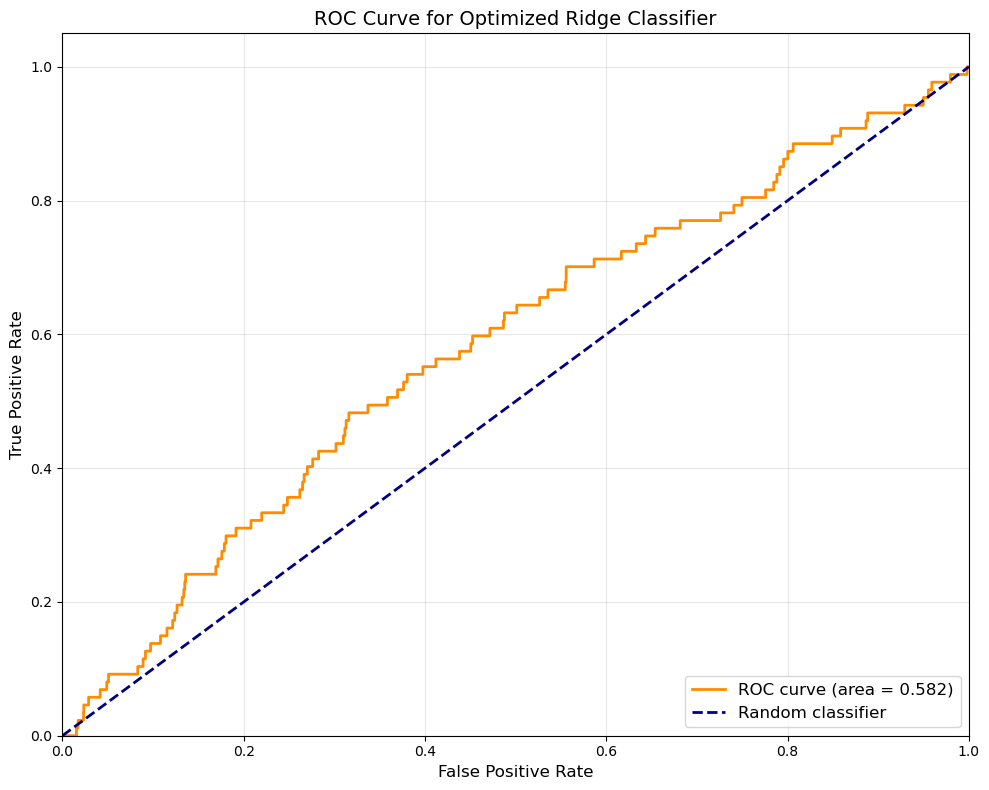

ROC AUC Score: 0.5818
Best Parameters: {'alpha': 10.0, 'class_weight': None, 'solver': 'auto'}


Exception ignored in: <function ResourceTracker.__del__ at 0x7f5d1e21b380>
Traceback (most recent call last):
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fbfb7927380>
Traceback (most recent call last):
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/rubinstein/.conda/envs/wildfire_prep/lib/python3.12/multiprocessing/resource_tracker.py",

In [ ]:
# Convert string labels to numeric values if needed
le = LabelEncoder()
if y_test.dtype == object:  # If y_test contains strings
    y_test_numeric = le.fit_transform(y_test)
else:
    y_test_numeric = y_test.copy()

# Get decision scores from the model
y_score = best_model.decision_function(X_test)

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_score)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Optimized Ridge Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")